Simplest simplest, let's start with a linear regression...

In [238]:
import pandas as pd
#just change the file name to train the model on different data
summary_statistics_df = pd.read_csv('cyano_culture_datasets/06-03-2025 culture/combined_dataset_summary_statistics.csv')
summary_statistics_df = summary_statistics_df.drop(columns=['Unnamed: 0'])
summary_statistics_df

,OD,delta_OD,mean_Temperature (C),mean_pH,mean_Dissolved Oxygen (mg/L),mean_Light Intensity (μmol photons m² s⁻¹),std_Temperature (C),std_pH,std_Dissolved Oxygen (mg/L),std_Light Intensity (μmol photons m² s⁻¹),...,median_Dissolved Oxygen (mg/L),median_Light Intensity (μmol photons m² s⁻¹),slope_Temperature (C),slope_pH,slope_Dissolved Oxygen (mg/L),slope_Light Intensity (μmol photons m² s⁻¹),first_last_diff_Temperature (C),first_last_diff_pH,first_last_diff_Dissolved Oxygen (mg/L),first_last_diff_Light Intensity (μmol photons m² s⁻¹)
0,0.395239,0.014435,19.841851,7.094231,5.688226,400.0,2.678635,0.027540,0.269249,0.0,...,5.68,400.0,0.002442,-2.491133e-05,0.000247,0.0,9.62,-0.104,0.88,0.0
1,0.394832,-0.000407,25.863776,7.023309,6.336660,400.0,1.042579,0.014520,0.101465,0.0,...,6.34,400.0,0.000953,-1.306813e-05,0.000086,0.0,3.65,-0.057,0.37,0.0
2,0.394368,-0.000464,28.316295,6.995618,6.564077,400.0,0.435622,0.003540,0.089364,0.0,...,6.57,400.0,0.000397,-2.402133e-06,0.000057,0.0,1.50,-0.008,0.13,0.0
3,0.392198,-0.002170,29.304068,6.985501,6.595900,400.0,0.205199,0.002906,0.074469,0.0,...,6.60,400.0,0.000189,-2.226345e-06,-0.000023,0.0,0.71,-0.010,-0.15,0.0
4,0.392198,0.000000,29.640000,6.982000,6.470000,400.0,NaN,NaN,NaN,NaN,...,6.47,400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,0.693603,0.000866,31.679400,7.433261,6.465261,400.0,0.008275,0.002358,0.149662,0.0,...,6.48,400.0,0.000006,1.471094e-06,0.000102,0.0,-0.01,0.005,0.24,0.0
177,0.693603,0.000000,31.650000,7.435000,6.630000,400.0,NaN,NaN,NaN,NaN,...,6.63,400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,0.694934,0.001331,31.665390,7.436575,6.696670,400.0,0.009762,0.001779,0.102515,0.0,...,6.70,400.0,0.000007,2.573285e-07,0.000058,0.0,0.00,0.004,0.12,0.0
179,0.694123,-0.000811,31.658531,7.439738,6.804846,400.0,0.009744,0.002763,0.083108,0.0,...,6.81,400.0,0.000007,1.914788e-06,0.000038,0.0,-0.01,0.004,0.02,0.0


In [239]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D 
from sklearn.ensemble import RandomForestRegressor

# --- Scikit-learn imports for modeling ---
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Configuration ---
CSV_FILE_PATH = None 
HF_COLUMNS = ['temperature (C)', 'pH', 'dO', 'light_intensity (lumens)']
plt.rcParams.update({'font.size': 16})

def train_and_evaluate_linear_regression(features_df):
    print("\n--- Training and Evaluating Linear Regression Model with 10-Fold Cross-Validation ---")
    MIN_SAMPLES_FOR_CV = 10 
    if features_df.empty or len(features_df) < MIN_SAMPLES_FOR_CV:
        print(f"Not enough data for 10-fold CV. Need {MIN_SAMPLES_FOR_CV}, found {len(features_df)}.")
        return

    y = features_df['delta_OD']
    X = features_df.drop(columns=['delta_OD', 'OD'])

    if X.empty: print("No features available."); return

    X_filled = X.fillna(X.mean())
    if X_filled.isna().any().any():
        cols_to_drop = X_filled.columns[X_filled.isna().all()].tolist()
        if cols_to_drop:
            X_filled = X_filled.drop(columns=cols_to_drop)
            print(f"Dropped all-NaN columns: {cols_to_drop}")
        if X_filled.empty or X_filled.isna().any().any() :
             print("Features are still problematic after NaN handling."); return
    
    y_aligned = y.loc[X_filled.index]
    if y_aligned.empty:
        print("Target variable y_aligned is empty. Cannot proceed."); return

    pipeline = Pipeline([('scaler', StandardScaler()), ('regressor', LinearRegression())])
    cv = KFold(n_splits=10, shuffle=True, random_state=42)

    mse_scores = cross_val_score(pipeline, X_filled, y_aligned, scoring='neg_mean_squared_error', cv=cv)
    mae_scores = cross_val_score(pipeline, X_filled, y_aligned, scoring='neg_mean_absolute_error', cv=cv)
    r2_scores = cross_val_score(pipeline, X_filled, y_aligned, scoring='r2', cv=cv)

    print("\nCross-Validation Model Evaluation Metrics (10-fold):")
    print(f"  Mean Squared Error (MSE): {-np.mean(mse_scores):.4f} (+/- {np.std(mse_scores):.4f})")
    print(f"  Root Mean Squared Error (RMSE): {np.sqrt(-np.mean(mse_scores)):.4f}")
    print(f"  Mean Absolute Error (MAE): {-np.mean(mae_scores):.4f} (+/- {np.std(mae_scores):.4f})")
    print(f"  R-squared (R²): {np.mean(r2_scores):.4f} (+/- {np.std(r2_scores):.4f})")
    cv_mae = -np.mean(mae_scores)  # Already done in your code
    std_dev_mae = np.std(mae_scores)

    delta_od_cv_predictions = cross_val_predict(pipeline, X_filled, y_aligned, cv=cv)

    if not y_aligned.empty:
        min_observed_delta_od = y_aligned.min()
        max_observed_delta_od = y_aligned.max()
        lower_bound = min_observed_delta_od
        upper_bound = max_observed_delta_od

        print(f"\nApplying prediction capping for delta_OD based on observed actual range: [{lower_bound:.4f}, {upper_bound:.4f}]")
        delta_od_cv_predictions_capped = np.clip(delta_od_cv_predictions, lower_bound, upper_bound)

        num_capped_low = np.sum(delta_od_cv_predictions < lower_bound)
        num_capped_high = np.sum(delta_od_cv_predictions > upper_bound)
        if num_capped_low > 0 or num_capped_high > 0:
            print(f"  Number of original predictions capped at lower bound: {num_capped_low}")
            print(f"  Number of original predictions capped at upper bound: {num_capped_high}")
        else:
            print("  No predictions were outside the observed actual range.")
    else:
        print("Warning: y_aligned is empty, cannot determine capping range. Using original predictions for plots.")
        delta_od_cv_predictions_capped = delta_od_cv_predictions 

    # --- Parity Plot (using CAPPED predictions) ---
    plt.figure(figsize=(9, 9)) # Adjusted size for better legend fit
    
    # Scatter plot of actual vs predicted
    scatter_points = plt.scatter(y_aligned, delta_od_cv_predictions_capped, alpha=0.7, edgecolors='k', s=50) # s for size

    # Draw orthogonal error lines
    for actual_val, pred_val in zip(y_aligned, delta_od_cv_predictions_capped):
        intersect_x = (actual_val + pred_val) / 2
        intersect_y = intersect_x 
        plt.plot([actual_val, intersect_x], [pred_val, intersect_y], color='gray', linestyle='--', linewidth=0.7, alpha=0.6)

    min_val = min(y_aligned.min(), delta_od_cv_predictions_capped.min()) - 0.002 # Small buffer
    max_val = max(y_aligned.max(), delta_od_cv_predictions_capped.max()) + 0.002 # Small buffer
    line_of_truth = plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2) 
    
    plt.xlabel("Actual delta_OD")
    plt.ylabel("Predicted delta_OD (Cross-Validated & Capped)")
    plt.ylabel(r'Predicted $\Delta$OD')
    plt.xlabel(r'Actual $\Delta$OD')
    plt.title("Parity Plot: Continuous Light (Linear Regression)")
    
    
    # Custom legend elements
    legend_elements = [
        scatter_points, # Use the returned artist from plt.scatter
        line_of_truth[0], # Use the first (and only) Line2D object from plt.plot
        Line2D([0], [0], color='gray', linestyle='--', lw=0.7, label='Orthogonal Error Lines')
    ]
    # Get labels from the artists themselves if they were set, or define here
    labels = ['Predictions', 'Perfect Fit (y=x)', 'Orthogonal Error Lines']
    plt.legend(legend_elements, labels)
    
    plt.xlim(min_val, max_val) # Set limits for a cleaner plot
    plt.ylim(min_val, max_val)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.gca().set_aspect('equal', adjustable='box') # Make it square
    # Set x and y ticks every 2 units from 0 to 10
    plt.yticks(np.arange(-0.0025, 0.015, 0.005))
    plt.xticks(np.arange(-0.0025, 0.015, 0.005))
    plt.show()

    # --- OD Time Course Plot (using CAPPED predictions) ---
    if not features_df.empty and not y_aligned.empty: 
        initial_actual_od_for_course = features_df['OD'].iloc[0] - features_df['delta_OD'].iloc[0]
        actual_od_course = np.concatenate(([initial_actual_od_for_course], features_df['OD'].loc[y_aligned.index].values))
        
        predicted_od_course = [initial_actual_od_for_course]
        current_predicted_od = initial_actual_od_for_course
        for pred_delta in delta_od_cv_predictions_capped: 
            current_predicted_od += pred_delta
            predicted_od_course.append(current_predicted_od)
        predicted_od_course = np.array(predicted_od_course)

  
        plot_timestamps = features_df.loc[y_aligned.index].index 
        if len(plot_timestamps) > 1:
            time_diff = plot_timestamps[1] - plot_timestamps[0]
            initial_timestamp = plot_timestamps[0] - time_diff
        elif len(plot_timestamps) == 1 :
             initial_timestamp = plot_timestamps[0] - pd.Timedelta(hours=1) 
        else: 
            initial_timestamp = pd.Timestamp.now() - pd.Timedelta(hours=1)

        #full_plot_timestamps = pd.to_datetime([initial_timestamp] + plot_timestamps.tolist())
        full_plot_timestamps = np.arange(len(summary_statistics_df) + 1)  # +1 for initial OD point


        
        # Calculate final MAE for OD values
        #mae_od_course = mean_absolute_error(actual_od_course[1:], predicted_od_course[1:])  # skip initial value

        # Plot with MAE included in legend
        plt.figure(figsize=(12, 6))
        plt.plot(full_plot_timestamps, actual_od_course, label='Experimental OD', marker='o', linestyle='-')
        plt.plot(full_plot_timestamps, predicted_od_course,
         label=f'Predicted OD (Linear Regression)\nMAE = {cv_mae:.4f} +/- {std_dev_mae:.4f}',
         marker='x', linestyle='--')

        plt.xlabel("Time [Days]")
        plt.ylabel("Optical Density (OD)")
        plt.title("Experimental vs. Reconstructed Predicted OD Time Course (Linear Regression)")
        plt.legend()
        plt.grid(False)
        #plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping OD Time Course plot due to insufficient data after alignment.")

    print("\n--- Training Final Model on All Data for Feature Importance ---")
    pipeline.fit(X_filled, y_aligned)
    coefficients_scaled = pipeline.named_steps['regressor'].coef_
    feature_names = X_filled.columns
    coefficients_df = pd.DataFrame(coefficients_scaled, feature_names, columns=['Coefficient'])
    sorted_coefficients = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)
    print("\nFeature Importance (Coefficients from model trained on all data, features were scaled):")
    print(sorted_coefficients)


In [240]:
def analyze_residual_distribution(y_true, y_pred):
    # Calculate residuals from capped predictions
    residuals = y_true - y_pred

    # --- Plot histogram with KDE and fitted PDFs ---
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=False, stat='density', bins=30, label='Residuals', color='skyblue')

    x_vals = np.linspace(residuals.min(), residuals.max(), 1000)
    gauss_pdf = norm.pdf(x_vals, *norm.fit(residuals))
    laplace_pdf = laplace.pdf(x_vals, *laplace.fit(residuals))

    plt.plot(x_vals, gauss_pdf, label='Gaussian Fit', color='blue')
    plt.plot(x_vals, laplace_pdf, label='Laplacian Fit', color='orange')
    plt.xlabel("Residual (Actual - Predicted)")
    plt.ylabel("Density")
    plt.title("Residual Distribution with Gaussian vs. Laplacian Fits")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Compute and print log-likelihoods ---
    loglik_gauss = norm.logpdf(residuals, *norm.fit(residuals)).sum()
    loglik_laplace = laplace.logpdf(residuals, *laplace.fit(residuals)).sum()

    print("\nLog-Likelihood Comparison:")
    print(f"  Gaussian: {loglik_gauss:.2f}")
    print(f"  Laplacian: {loglik_laplace:.2f}")

    if loglik_gauss > loglik_laplace:
        print("📊 Residuals are better modeled as Gaussian → Cite RMSE as primary metric.")
    else:
        print("📊 Residuals are better modeled as Laplacian → Cite MAE as primary metric.")



--- Training and Evaluating Linear Regression Model with 10-Fold Cross-Validation ---

Cross-Validation Model Evaluation Metrics (10-fold):
  Mean Squared Error (MSE): 0.0000 (+/- 0.0000)
  Root Mean Squared Error (RMSE): 0.0027
  Mean Absolute Error (MAE): 0.0012 (+/- 0.0005)
  R-squared (R²): -0.9283 (+/- 1.3341)

Applying prediction capping for delta_OD based on observed actual range: [-0.0022, 0.0144]
  Number of original predictions capped at lower bound: 1
  Number of original predictions capped at upper bound: 0


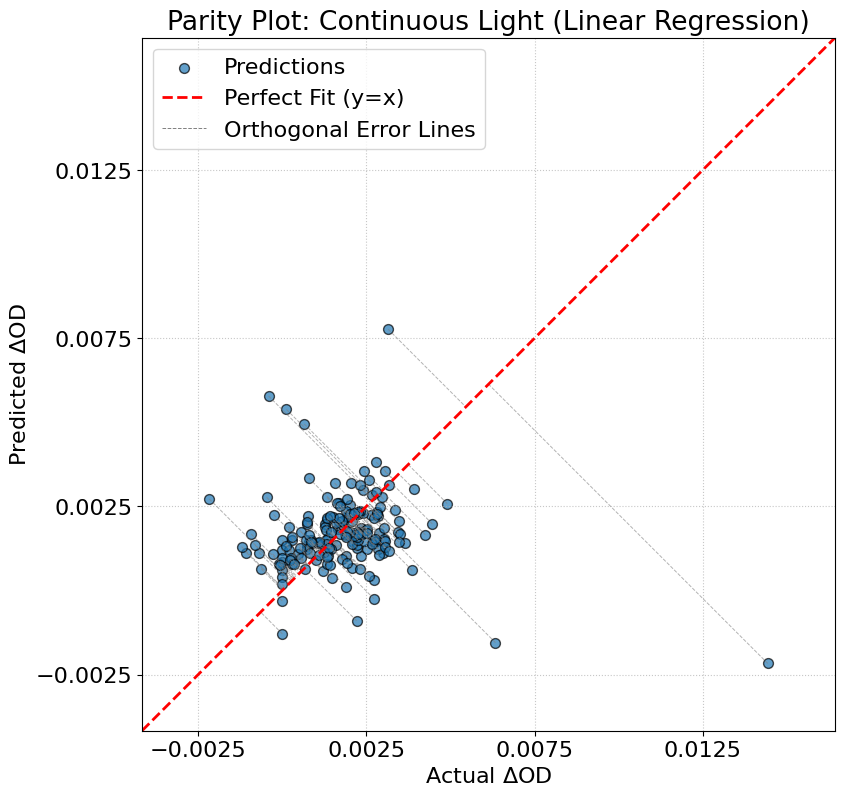

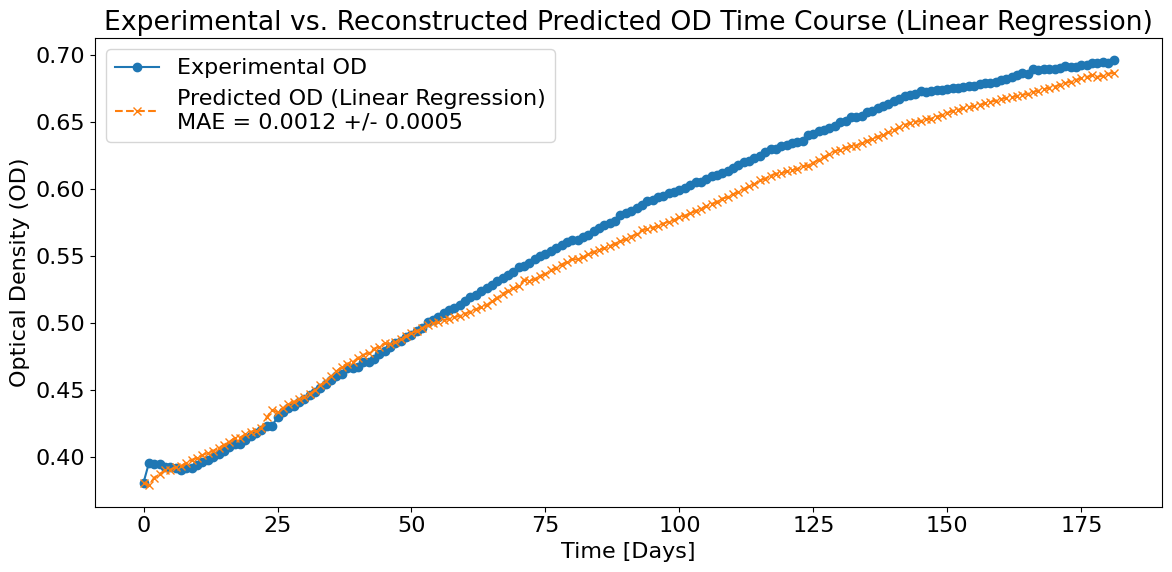


--- Training Final Model on All Data for Feature Importance ---

Feature Importance (Coefficients from model trained on all data, features were scaled):
                                                     Coefficient
mean_pH                                            -1.479925e-01
median_pH                                           1.027159e-01
max_pH                                              2.369102e-02
min_pH                                              2.147652e-02
min_Temperature (C)                                -1.077843e-02
max_Temperature (C)                                 8.821298e-03
std_Temperature (C)                                -6.532698e-03
slope_Temperature (C)                              -6.063832e-03
first_last_diff_Temperature (C)                     5.567819e-03
mean_Temperature (C)                               -5.302907e-03
median_Temperature (C)                              1.183071e-03
std_pH                                              5.291955e-04
f

In [241]:
train_and_evaluate_linear_regression(summary_statistics_df)

In [242]:
def analyze_residual_distribution(y_true, y_pred):
    # Calculate residuals from capped predictions
    residuals = y_true - y_pred

    # --- Plot histogram with KDE and fitted PDFs ---
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=False, stat='density', bins=30, label='Residuals', color='skyblue')

    x_vals = np.linspace(residuals.min(), residuals.max(), 1000)
    gauss_pdf = norm.pdf(x_vals, *norm.fit(residuals))
    laplace_pdf = laplace.pdf(x_vals, *laplace.fit(residuals))

    plt.plot(x_vals, gauss_pdf, label='Gaussian Fit', color='blue')
    plt.plot(x_vals, laplace_pdf, label='Laplacian Fit', color='orange')
    plt.xlabel("Residual (Actual - Predicted)")
    plt.ylabel("Density")
    plt.title("Residual Distribution with Gaussian vs. Laplacian Fits")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Compute and print log-likelihoods ---
    loglik_gauss = norm.logpdf(residuals, *norm.fit(residuals)).sum()
    loglik_laplace = laplace.logpdf(residuals, *laplace.fit(residuals)).sum()

    print("\nLog-Likelihood Comparison:")
    print(f"  Gaussian: {loglik_gauss:.2f}")
    print(f"  Laplacian: {loglik_laplace:.2f}")

    if loglik_gauss > loglik_laplace:
        print("📊 Residuals are better modeled as Gaussian → Cite RMSE as primary metric.")
    else:
        print("📊 Residuals are better modeled as Laplacian → Cite MAE as primary metric.")


In [243]:
# --- Machine Learning Model Training and Evaluation ---
def train_and_evaluate_random_forest(features_df):
    model_name = "Random Forest Regressor" # Define model name for outputs
    print(f"\n--- Training and Evaluating {model_name} with 10-Fold Cross-Validation ---")
    MIN_SAMPLES_FOR_CV = 10 
    if features_df.empty or len(features_df) < MIN_SAMPLES_FOR_CV:
        print(f"Not enough data for 10-fold CV. Need {MIN_SAMPLES_FOR_CV}, found {len(features_df)}.")
        return

    y = features_df['delta_OD']
    X = features_df.drop(columns=['delta_OD', 'OD'])

    if X.empty: print("No features available."); return

    X_filled = X.fillna(X.mean())
    if X_filled.isna().any().any():
        cols_to_drop = X_filled.columns[X_filled.isna().all()].tolist()
        if cols_to_drop:
            X_filled = X_filled.drop(columns=cols_to_drop)
            print(f"Dropped all-NaN columns: {cols_to_drop}")
        if X_filled.empty or X_filled.isna().any().any() :
             print("Features are still problematic after NaN handling."); return
    
    y_aligned = y.loc[X_filled.index]
    if y_aligned.empty:
        print("Target variable y_aligned is empty. Cannot proceed."); return

    # Define the pipeline with StandardScaler and RandomForestRegressor
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42)) # Using RandomForestRegressor
    ])
    cv = KFold(n_splits=10, shuffle=True, random_state=42)

    mse_scores = cross_val_score(pipeline, X_filled, y_aligned, scoring='neg_mean_squared_error', cv=cv)
    mae_scores = cross_val_score(pipeline, X_filled, y_aligned, scoring='neg_mean_absolute_error', cv=cv)
    r2_scores = cross_val_score(pipeline, X_filled, y_aligned, scoring='r2', cv=cv)

    print(f"\nCross-Validation Model Evaluation Metrics ({model_name}, 10-fold):")
    print(f"  Mean Squared Error (MSE): {-np.mean(mse_scores):.4f} (+/- {np.std(mse_scores):.4f})")
    print(f"  Root Mean Squared Error (RMSE): {np.sqrt(-np.mean(mse_scores)):.4f}")
    print(f"  Mean Absolute Error (MAE): {-np.mean(mae_scores):.4f} (+/- {np.std(mae_scores):.4f})")
    print(f"  R-squared (R²): {np.mean(r2_scores):.4f} (+/- {np.std(r2_scores):.4f})")
    cv_mae = -np.mean(mae_scores)  # Already done in your code
    std_dev_mae = np.std(mae_scores)

    delta_od_cv_predictions = cross_val_predict(pipeline, X_filled, y_aligned, cv=cv)

    if not y_aligned.empty:
        min_observed_delta_od = y_aligned.min()
        max_observed_delta_od = y_aligned.max()
        lower_bound = min_observed_delta_od
        upper_bound = max_observed_delta_od

        print(f"\nApplying prediction capping for delta_OD based on observed actual range: [{lower_bound:.4f}, {upper_bound:.4f}]")
        delta_od_cv_predictions_capped = np.clip(delta_od_cv_predictions, lower_bound, upper_bound)

        num_capped_low = np.sum(delta_od_cv_predictions < lower_bound)
        num_capped_high = np.sum(delta_od_cv_predictions > upper_bound)
        if num_capped_low > 0 or num_capped_high > 0:
            print(f"  Number of original predictions capped at lower bound ({lower_bound:.4f}): {num_capped_low}")
            print(f"  Number of original predictions capped at upper bound ({upper_bound:.4f}): {num_capped_high}")
        else:
            print("  No predictions were outside the observed actual range.")
    else:
        print("Warning: y_aligned is empty, cannot determine capping range. Using original predictions for plots.")
        delta_od_cv_predictions_capped = delta_od_cv_predictions 

    # --- Parity Plot (using CAPPED predictions) ---
    plt.figure(figsize=(9, 9)) 
    scatter_points = plt.scatter(y_aligned, delta_od_cv_predictions_capped, alpha=0.7, edgecolors='k', s=50) 
    for actual_val, pred_val in zip(y_aligned, delta_od_cv_predictions_capped):
        intersect_x = (actual_val + pred_val) / 2
        intersect_y = intersect_x 
        plt.plot([actual_val, intersect_x], [pred_val, intersect_y], color='gray', linestyle='--', linewidth=0.7, alpha=0.6)

    min_val_plot = min(y_aligned.min(), delta_od_cv_predictions_capped.min()) - 0.002 
    max_val_plot = max(y_aligned.max(), delta_od_cv_predictions_capped.max()) + 0.002
    line_of_truth = plt.plot([min_val_plot, max_val_plot], [min_val_plot, max_val_plot], 'r--', lw=2) 
    
    plt.ylabel(r'Predicted $\Delta$OD')
    plt.xlabel(r'Actual $\Delta$OD')
    plt.title("Parity Plot: Continuous Light (Random Forest Regressor)")

    legend_elements = [
        scatter_points, 
        line_of_truth[0], 
        Line2D([0], [0], color='gray', linestyle='--', lw=0.7, label='Orthogonal Error Lines')
    ]
    labels = ['Predictions', 'Perfect Fit (y=x)', 'Orthogonal Error Lines']
    plt.legend(legend_elements, labels)
    
    plt.xlim(min_val_plot, max_val_plot) 
    plt.ylim(min_val_plot, max_val_plot)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.gca().set_aspect('equal', adjustable='box') 
    plt.yticks(np.arange(-0.0025, 0.015, 0.005))
    plt.xticks(np.arange(-0.0025, 0.015, 0.005))
    plt.show()

    # --- OD Time Course Plot (using CAPPED predictions) ---
    if not features_df.empty and not y_aligned.empty: 
        initial_actual_od_for_course = features_df['OD'].iloc[0] - features_df['delta_OD'].iloc[0]
        actual_od_course = np.concatenate(([initial_actual_od_for_course], features_df['OD'].loc[y_aligned.index].values))
        
        predicted_od_course = [initial_actual_od_for_course]
        current_predicted_od = initial_actual_od_for_course
        for pred_delta in delta_od_cv_predictions_capped: 
            current_predicted_od += pred_delta
            predicted_od_course.append(current_predicted_od)
        predicted_od_course = np.array(predicted_od_course)

        plot_timestamps = features_df.loc[y_aligned.index].index 
        if len(plot_timestamps) > 1:
            time_diff = plot_timestamps[1] - plot_timestamps[0]
            initial_timestamp = plot_timestamps[0] - time_diff
        elif len(plot_timestamps) == 1 :
             initial_timestamp = plot_timestamps[0] - pd.Timedelta(hours=1) 
        else: 
            initial_timestamp = pd.Timestamp.now() - pd.Timedelta(hours=1)

        #full_plot_timestamps = pd.to_datetime([initial_timestamp] + plot_timestamps.tolist())
        full_plot_timestamps = np.arange(len(summary_statistics_df) + 1)  # +1 for initial OD point


        plt.figure(figsize=(12, 6))
        # Calculate final MAE for OD values
        #mae_od_course = mean_absolute_error(actual_od_course[1:], predicted_od_course[1:])  # skip initial value

        # Plot with MAE included in legend
        plt.plot(full_plot_timestamps, actual_od_course, label='Experimental OD', marker='o', linestyle='-')
        plt.plot(full_plot_timestamps, predicted_od_course,
         label=f'Predicted OD (Random Forest)\nMAE = {cv_mae:.4f} +/- {std_dev_mae:.4f}',
         marker='x', linestyle='--')

        plt.xlabel("Time [Days]")
        plt.ylabel("Optical Density (OD)")
        plt.title(f"Experimental vs. Reconstructed Predicted OD Time Course ({model_name})")
        plt.legend()
        plt.grid(False)
        #plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping OD Time Course plot due to insufficient data after alignment.")

    
    # --- Feature Importance (for Random Forest) ---
    print(f"\n--- Training Final {model_name} on All Data for Feature Importance ---")
    pipeline.fit(X_filled, y_aligned) # Fit the pipeline on all data
    
    # Extract feature importances from the RandomForestRegressor step
    if hasattr(pipeline.named_steps['regressor'], 'feature_importances_'):
        importances = pipeline.named_steps['regressor'].feature_importances_
        feature_names = X_filled.columns
        
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        sorted_importance_df = importance_df.sort_values(by='Importance', ascending=False)
        
        print(f"\nFeature Importance ({model_name} - Impurity-based):")
        print(sorted_importance_df)
        print("\nNote: Importance values sum to 1 (approximately) and indicate how much each feature contributed to reducing variance (impurity) in the model.")
    else:
        print(f"Feature importances are not available for the regressor: {pipeline.named_steps['regressor']}.")
    
    analyze_residual_distribution(y_aligned.values, delta_od_cv_predictions_capped)




--- Training and Evaluating Random Forest Regressor with 10-Fold Cross-Validation ---

Cross-Validation Model Evaluation Metrics (Random Forest Regressor, 10-fold):
  Mean Squared Error (MSE): 0.0000 (+/- 0.0000)
  Root Mean Squared Error (RMSE): 0.0015
  Mean Absolute Error (MAE): 0.0009 (+/- 0.0003)
  R-squared (R²): 0.0904 (+/- 0.3374)

Applying prediction capping for delta_OD based on observed actual range: [-0.0022, 0.0144]
  No predictions were outside the observed actual range.


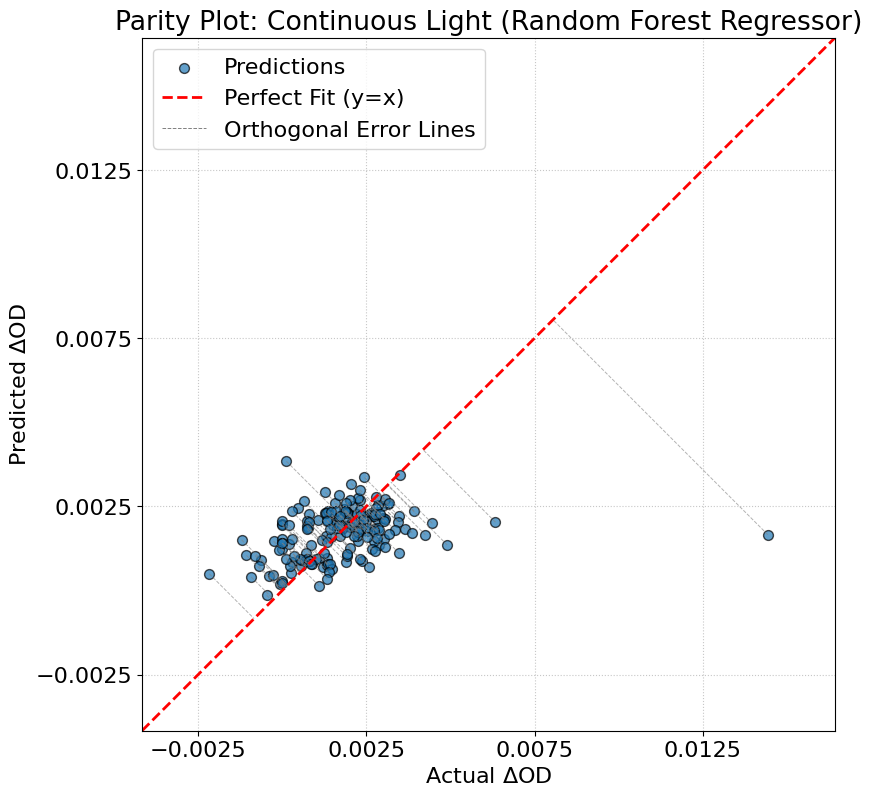

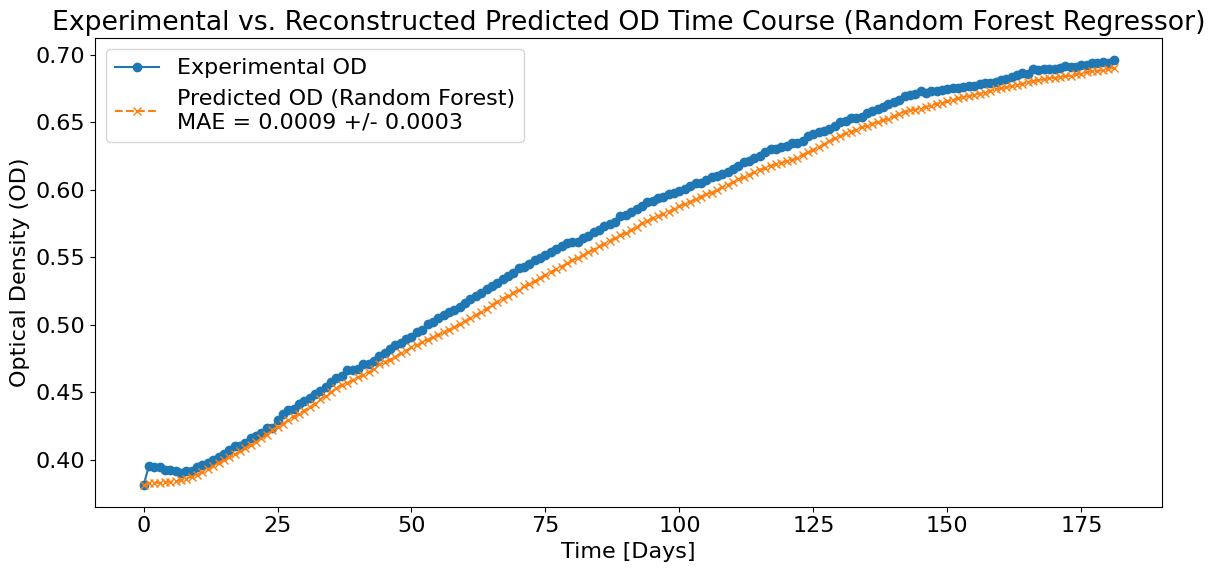


--- Training Final Random Forest Regressor on All Data for Feature Importance ---

Feature Importance (Random Forest Regressor - Impurity-based):
                                              Feature  Importance
5                                              std_pH    0.114928
20                              slope_Temperature (C)    0.107012
4                                 std_Temperature (C)    0.079688
10                        min_Dissolved Oxygen (mg/L)    0.069707
9                                              min_pH    0.057961
16                             median_Temperature (C)    0.053126
0                                mean_Temperature (C)    0.052662
24                    first_last_diff_Temperature (C)    0.052452
12                                max_Temperature (C)    0.042660
6                         std_Dissolved Oxygen (mg/L)    0.041280
17                                          median_pH    0.039692
8                                 min_Temperature (C)    0.03

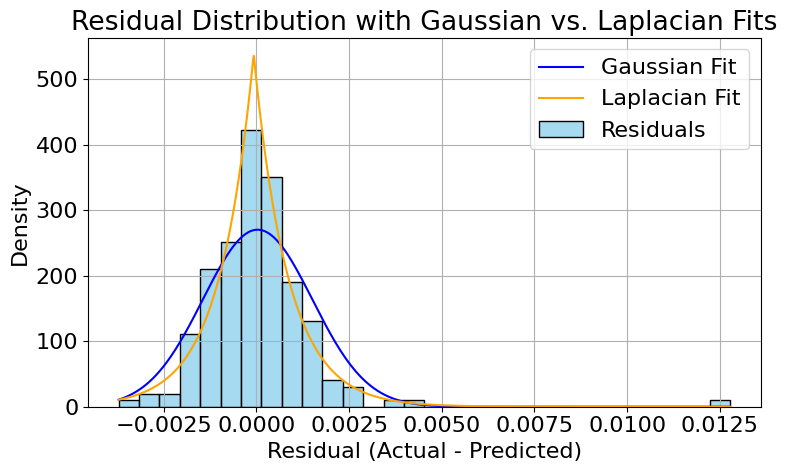


Log-Likelihood Comparison:
  Gaussian: 923.13
  Laplacian: 957.31
📊 Residuals are better modeled as Laplacian → Cite MAE as primary metric.


In [244]:
train_and_evaluate_random_forest(summary_statistics_df)

# Shall we throw a 1D-CNN at it?